In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data

In [4]:
# file paths
train_path = "../data/preprocessed/train_vectors_scaled.csv"
valid_path = "../data/preprocessed/validation_vectors_scaled.csv"
test_path = "../data/preprocessed/test_vectors_scaled.csv"
gen_path = "../data/preprocessed/generalisation_vectors_scaled.csv"

In [5]:
# load the dataframes
train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df = pd.read_csv(test_path)
gen_df = pd.read_csv(gen_path)

In [15]:
def preprocess(df, label_encoder = None):
    # get target features
    data_df = df.drop(columns=['Type'])
    if "is_synthetic" in data_df.columns:
        data_df.drop(columns=['is_synthetic'], inplace = True)
    data_df = data_df.reindex(sorted(data_df.columns), axis=1)
    target_df = df['Type']

    # encode target labels
    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(target_df)
    target_df = label_encoder.transform(target_df)

    X = data_df.to_numpy()
    y = target_df

    return X, y, label_encoder

In [16]:
# preprocess the datasets
X_train, y_train, target_label_encoder =  preprocess(train_df)
X_valid, y_valid, _ =  preprocess(valid_df, label_encoder=target_label_encoder)
X_test, y_test, _ =  preprocess(test_df, label_encoder=target_label_encoder)
X_gen, y_gen, _ =  preprocess(gen_df, label_encoder=target_label_encoder)

In [17]:
print(X_train.shape, X_valid.shape, X_test.shape, X_gen.shape)

(1346829, 24) (1247266, 24) (1233449, 24) (2452610, 24)


# Train the model

In [37]:
# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# Train the classifier on the training data and evaluate on the validation set
xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=['merror'], early_stopping_rounds=10)

c:\Users\Maya\.conda\envs\ddos\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Maya\.conda\envs\ddos\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.28786
[1]	validation_0-merror:0.22616
[2]	validation_0-merror:0.21883
[3]	validation_0-merror:0.21366
[4]	validation_0-merror:0.21601
[5]	validation_0-merror:0.21618
[6]	validation_0-merror:0.22440
[7]	validation_0-merror:0.21008
[8]	validation_0-merror:0.20446
[9]	validation_0-merror:0.19835
[10]	validation_0-merror:0.19948
[11]	validation_0-merror:0.19874
[12]	validation_0-merror:0.19764
[13]	validation_0-merror:0.19744
[14]	validation_0-merror:0.19624
[15]	validation_0-merror:0.19683
[16]	validation_0-merror:0.19505
[17]	validation_0-merror:0.19441
[18]	validation_0-merror:0.19460
[19]	validation_0-merror:0.19355
[20]	validation_0-merror:0.19366
[21]	validation_0-merror:0.19337
[22]	validation_0-merror:0.19326
[23]	validation_0-merror:0.19360
[24]	validation_0-merror:0.19319
[25]	validation_0-merror:0.19272
[26]	validation_0-merror:0.19292
[27]	validation_0-merror:0.19284
[28]	validation_0-merror:0.19275
[29]	validation_0-merror:0.19277
[30]	validation_0-me

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Accuracy: 0.8164780221962967


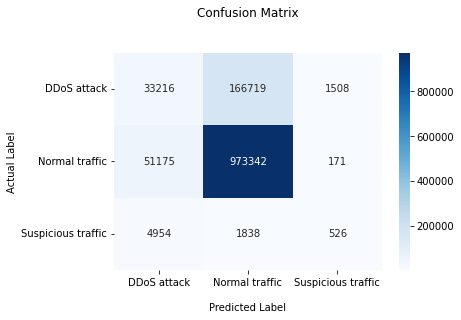

In [51]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_test, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

In [45]:
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_valid, return_counts=True)[1] / len(y_valid))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))
print(np.unique(y_gen, return_counts=True)[1] / len(y_gen))

[0.33333333 0.33333333 0.33333333]
[0.24466874 0.7369687  0.01836256]
[0.16331685 0.8307502  0.00593296]
[0.26188917 0.57957074 0.15854009]


Accuracy: 0.9407534289802194


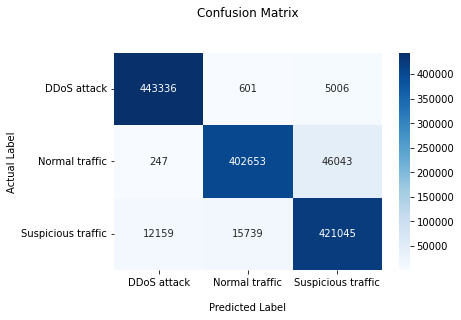

In [52]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_train)

# Calculate accuracy of the model
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_train, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.6377853641484655


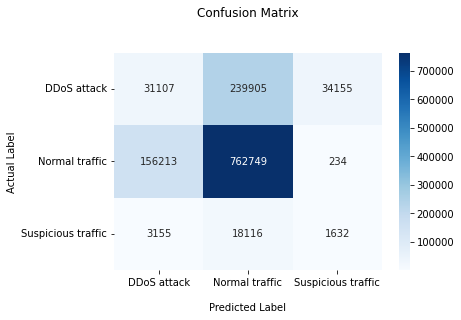

In [53]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_valid)

# Calculate accuracy of the model
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_valid, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.8670086153118515


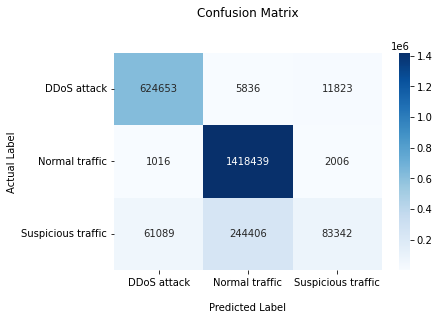

In [55]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_gen)

# Calculate accuracy of the model
accuracy = accuracy_score(y_gen, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_gen, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

In [60]:
train_df.columns

Index(['Port number', 'Packet speed', 'Data speed', 'Avg packet len',
       'Source IP count', 'victim IP num', 'time_of_day', 'Significant flag',
       'CLDAP', 'Generic UDP', 'CoAP', 'NTP', 'SYN Attack', 'CHARGEN', 'RDP',
       'High volume traffic', 'IPv4 fragmentation', 'Suspicious traffic',
       'SSDP', 'TCP Anomaly', 'SNMP', 'DNS', 'is_weekday', 'Type',
       'is_synthetic', 'other_attack_codes'],
      dtype='object')

In [63]:
train_df.reindex(sorted(train_df.columns), axis=1).drop(columns=['Type', 'is_synthetic']).columns

Index(['Avg packet len', 'CHARGEN', 'CLDAP', 'CoAP', 'DNS', 'Data speed',
       'Generic UDP', 'High volume traffic', 'IPv4 fragmentation', 'NTP',
       'Packet speed', 'Port number', 'RDP', 'SNMP', 'SSDP', 'SYN Attack',
       'Significant flag', 'Source IP count', 'Suspicious traffic',
       'TCP Anomaly', 'is_weekday', 'other_attack_codes', 'time_of_day',
       'victim IP num'],
      dtype='object')

In [64]:
feature_importance= xgb_classifier.feature_importances_

# Map feature importance scores to feature names

feature_names = train_df.reindex(sorted(train_df.columns), axis=1).drop(columns=['Type', 'is_synthetic']).columns
feature_importance_map = dict(zip(feature_names, feature_importance))

# Sort feature importance scores
sorted_feature_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Print feature importance scores
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

High volume traffic: 0.39099767804145813
Suspicious traffic: 0.15317358076572418
victim IP num: 0.13724973797798157
Significant flag: 0.07377023249864578
Avg packet len: 0.05506071820855141
CLDAP: 0.04448249191045761
Source IP count: 0.031933121383190155
Port number: 0.030810993164777756
Generic UDP: 0.017998188734054565
Data speed: 0.017854852601885796
DNS: 0.01346905529499054
time_of_day: 0.013193248771131039
is_weekday: 0.007203258108347654
NTP: 0.004250317346304655
Packet speed: 0.0034009015653282404
IPv4 fragmentation: 0.0023525631986558437
CoAP: 0.002037700032815337
SYN Attack: 0.000728628714568913
SNMP: 3.2814750738907605e-05
CHARGEN: 0.0
RDP: 0.0
SSDP: 0.0
TCP Anomaly: 0.0
other_attack_codes: 0.0
